# LSTM PREDICTION

LSTMs (Long Short Term Memory) are recurrent neural networks composed of one (or more) sequence of LSTM cells/units . These cells have much more internal parameters to train than classic/simple perceptrons, they have a complex internal structure allowing them to remember or forget information, extracted from inputs. They also take two inputs : a new data point, and the output of the previous cell (which itself was given the previous data point, and the prev-prev cell output, etc.). They were invented to process sequential data ; in this project, we use them for time series data.

### Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

import pickle

### Data loading

In [2]:
#We load the cleaned dataset (the one where NaN were replaced by the minute average of the missing variable)
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite_minute_mean_na.csv", sep=',', parse_dates=["DateTime"])

### Data preprocessing

In [3]:
timeframe = "3h" #Timeframe we will average on. Time steps will be steps of that length

df_lstm = df.set_index('DateTime')
df_lstm = df_lstm.resample(timeframe).mean() #We average each variable over the specified timeframe
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
df_lstm.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
DateTime,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,2006-12-16
2006-12-16 18:00:00,3.433667,0.080122,233.961389,14.673333,0.0,2.716667,16.777778,2006-12-16
2006-12-16 21:00:00,2.439400,0.068089,238.846111,10.488889,0.0,0.211111,7.216667,2006-12-16


In [4]:
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date') # load temperature data
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
temperatures.head(3)

,min_t,max_t,avg_t
Date,,,
2006-01-02,3.0,7.6,2.30
2006-01-03,3.9,6.8,1.45
2006-01-04,4.5,6.9,1.20


In [5]:
df_lstm = df_lstm.join(temperatures, how="left", on='Date') # we add the temperature columns to the main dataset
df_lstm = df_lstm.drop(columns=['Date','avg_t', 'Voltage', 'Global_intensity']) #We drop avg_t, voltage, and intensity because they give no new information (and we suspect voltage's measurements to be wrong/inaccurate after seeing it's distribution)
df_lstm.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5


In [6]:
# These columns are important for the model, because time of the day, day of the week, and month of the year heavily impact the power consumption.
# We unfortunately tried adding them to the LSTM model very late, after the final presentation and after we had already given up the LSTM method and tried random forest instead.
# After having successfully implemented and tested the random forest, we realized it would be interesting to try giving the columns to the LSTM too.
# It was indeed the missing data the LSTM needed in order to learn the cycles the data follows.
df_lstm["Hour"] = df_lstm.index.hour + df_lstm.index.minute/60 #Hour of the day, from 0.0 to 23.99 (it's a float because when we sample in 15min intervals, it will have non integer values, like '15.25' for 3:15pm)
df_lstm["Day"] = df_lstm.index.dayofweek # Day of the week, from 0 to 6
df_lstm["Month"] = df_lstm.index.month # Month of the year, from 0 to 11
df_lstm.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
DateTime,,,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5,15.0,5,12
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5,18.0,5,12
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5,21.0,5,12


In [7]:
# Check if there are any NaNs in the data
print(df_lstm.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
min_t                    0
max_t                    0
Hour                     0
Day                      0
Month                    0
dtype: int64


### Scaling

In [8]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_lstm[df_lstm.columns] = scaler.fit_transform(df_lstm)
df_lstm.describe()

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
count,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000
mean,-0.652902,-0.581935,-0.913692,-0.922883,-0.352936,0.141051,0.021381,0.000186,-0.000289,-0.008885
std,0.287086,0.179776,0.196272,0.188236,0.611017,0.361468,0.379395,0.654709,0.666696,0.621130
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.902554,-0.702033,-1.000000,-0.986801,-0.873678,-0.117460,-0.258228,-0.428571,-0.666667,-0.636364
50%,-0.711277,-0.624265,-1.000000,-0.980201,-0.544797,0.155556,0.032911,0.142857,0.000000,-0.090909
75%,-0.472789,-0.521939,-0.997007,-0.968652,0.106566,0.441270,0.316456,0.714286,0.666667,0.454545
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preparation of the dataset for supervised learning

The next function reorganizes the dataset to make it suited for supervised learning. A column is added that holds the value for the next time frame of the value we want to predict.

In [9]:
def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    columns = []
    columns.append(data.shift(1))
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

In [10]:
col_to_predict="Global_active_power"
df_lstm = data_to_supervised(df_lstm, col_to_predict)
df_lstm.head(5)

,Global_active_power(t-1),Global_reactive_power(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),min_t(t-1),max_t(t-1),Hour(t-1),Day(t-1),Month(t-1),Global_active_power(t)
DateTime,,,,,,,,,,,
2006-12-16 18:00:00,0.511114,-0.226075,-1.0,-0.968652,0.688926,-0.415873,-0.321519,0.428571,0.666667,1.0,0.217720
2006-12-16 21:00:00,0.217720,-0.729220,-1.0,-0.838640,0.680579,-0.415873,-0.321519,0.714286,0.666667,1.0,-0.151900
2006-12-17 00:00:00,-0.151900,-0.769888,-1.0,-0.987461,-0.277129,-0.415873,-0.321519,1.000000,0.666667,1.0,-0.213742
2006-12-17 03:00:00,-0.213742,-0.642215,-1.0,-0.479954,-1.000000,-0.193651,-0.367089,-1.000000,1.000000,1.0,-0.330774
2006-12-17 06:00:00,-0.330774,-0.737256,-1.0,-0.970302,-0.548136,-0.193651,-0.367089,-0.714286,1.000000,1.0,-0.462225


### LSTM MODELING

Train test split

In [11]:
values = df_lstm.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 9224
(9224, 1, 10) (9224,) (2306, 1, 10) (2306,)


Creation of the model's structure

In [12]:
model = Sequential()
#recurrent_activation ='selu' # 1er place
#recurrent_activation ='softsign' # 2e place

model.add(LSTM(125, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh',return_sequences=True))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')
#model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001),
             # loss=tensorflow.keras.losses.MeanSquaredError(),
             # metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               68000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 68,126
Trainable params: 68,126
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=25, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/250
369/369 [==============================] - 3s 3ms/step - loss: 0.2164 - val_loss: 0.1663
Epoch 2/250
369/369 [==============================] - 1s 2ms/step - loss: 0.2007 - val_loss: 0.1580
Epoch 3/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1935 - val_loss: 0.1562
Epoch 4/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1890 - val_loss: 0.1553
Epoch 5/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1869 - val_loss: 0.1549
Epoch 6/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1851 - val_loss: 0.1538
Epoch 7/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1845 - val_loss: 0.1533
Epoch 8/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1830 - val_loss: 0.1523
Epoch 9/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1821 - val_loss: 0.1519
Epoch 10/250
369/369 [==============================] - 1s 2ms/step - loss: 0.1810 - val_lo

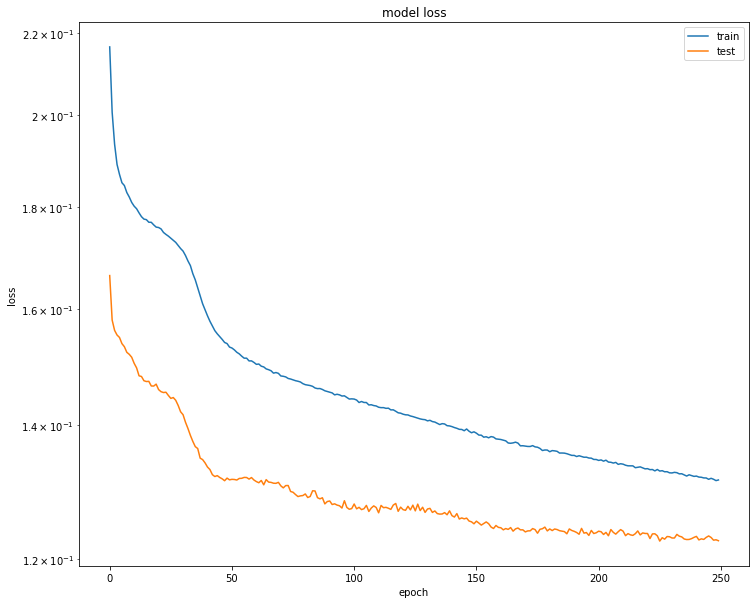

In [26]:
# Evolution of training loss and test loss over epochs.
# The model is underfit if the test loss looks like it could further decrease with additional training (if it's not yet flat).
# The model is overfit if the test loss increases again after too much training.

plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.yscale('log')
plt.show()

In [15]:
test_X_temp = test_X.copy()
test_y_temp = test_y.copy()

size = df_lstm.shape[1]-1
# make a prediction
yhat = model.predict(test_X_temp)
test_X_temp = test_X_temp.reshape((test_X_temp.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_temp[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_temp = test_y_temp.reshape((len(test_y_temp), 1))
inv_y = np.concatenate((test_y_temp, test_X_temp[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.453


In [33]:
# R² and adjusted R²
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(f"R-squared: {round(r2, 4)}")
print(f"Adjusted R-squared: {round(r_adjusted, 4)}")

R-squared: 0.454
Adjusted R-squared: 0.4537


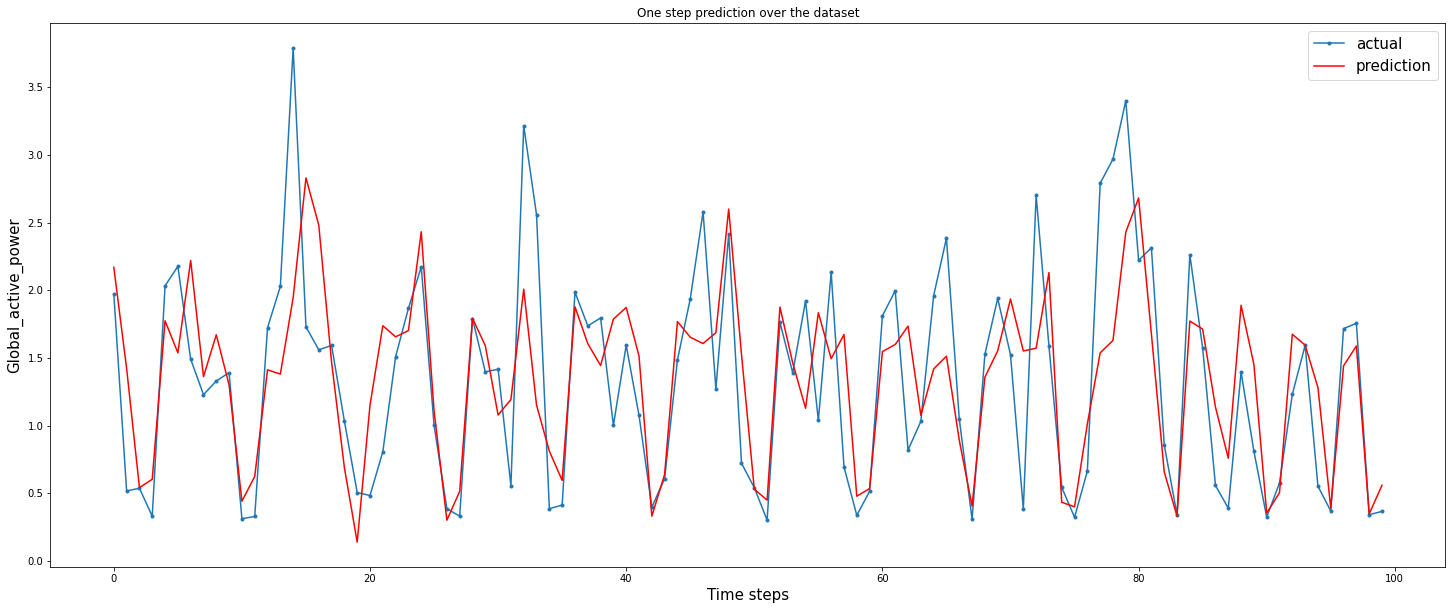

In [18]:
nbr_steps = 100
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(25,10))
plt.title("One step prediction over the dataset")
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time steps', size=15)
plt.legend(fontsize=15)
plt.show()

The graph above shows the prediction results when the model is given real data at each step. It predicts only one step ahead each time. 

Serializing the trained model to be able to use it later :

In [23]:
#serialize model
col_to_predict="Global_active_power"
model_type = "LSTM"
path = f"models/{timeframe}/{model_type}/"
if(not os.path.exists(path)):
    os.makedirs(path)
filename =f"{path}{col_to_predict}"
model.save(filename)
print(f"'{col_to_predict}' predicting model saved on disk as {filename}")

INFO:tensorflow:Assets written to: models/3h/LSTM/Global_active_power\assets


INFO:tensorflow:Assets written to: models/3h/LSTM/Global_active_power\assets


'Global_active_power' predicting model saved on disk as models/3h/LSTM/Global_active_power


Summary :


When we first worked on LSTM models, we thought that the network would be capable of identifying the periodicities and timings of the data on it's own, without having to add any time/date columns. We were wrong, and the models performed poorly despite all of our efforts and tuning. As shown during the final presentation, the model was constantly lagging, the output was replicating the real data (the input), but 1 step late ; it was not able to remember/predict the periodic increases and decreases of the power consumption. We tested many model structures (we tried different lengths of LSTM sequences, single layer vs multiple parallel layers of LSTM cells, all the different activation functions, etc.), tuned the model hyperparameters, but nothing would do the trick.  

It's only after taking a break from LSTMs and spending time on developping an alternative method using Random Forest, that we understood what was missing, and how to build a successful LSTM model for this dataset. What applied the same additional processing on the data that we did for the Random Forest : we added the 3 additional columns 'Hour', 'Day', and 'Month'. The LSTM, with this additional time data, finally became capable of actually predicting and not simply replicating. As we we can see in the last chart above, the model manages most of the time to predict with the right timing when to increase or lower the consumption, without waiting for the signal to move in that direction.


The next step of this project, if we had more time, would be building multistep forecasting, like we did for the Random Forest model. We couldn't re-use the same functions since the input format of the LSTM model is more complex than for Random Forest.